In [1]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTKC7NL/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTKC7NL/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTKC7NL/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [2]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']
training_sentences = []
training_labels = []

testing_sentences =[]
testing_labels = []

for s, l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

for s, l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

In [3]:
training_sentences = np.array(training_sentences)
testing_sentences = np.array(testing_sentences)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)



In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<oov>'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) # vocabulary를 만듦

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,truncating=trunc_type)


In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [6]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(padded[3])
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <oov> into a big arm chair and <oov> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <oov> to cross no dangerous waters just a warm and witty <oov> through new york life at its best a family film in every sense and one that deserves the praise it received
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   12    7    2  241    5   20   16    4 8776 2707 2653
   52    2  358    5    2  180   68  138 1401   17   92  203  968   15
   23    1   81    4  192 3109 3037    3    1   16    4  376    5  632
  387  352   37 6355    3 5559 1928   15  208 8596 3433    2  112  365
   48   24   55    1    6 1657   55 1818 4312   41    4 2263

In [11]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.SimpleRNN(units=64, return_sequences=True))
# Embedding(7, 2, input_length=5)
# 7은 단어의 개수. 즉, 단어 집합(vocabulary)의 크기이다.
# 2는 임베딩한 후의 벡터의 크기이다.
# 5는 각 입력 시퀀스의 길이. 즉, input_length이다.

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 120, 64)           5184      
_________________________________________________________________
dense_2 (Dense)              (None, 120, 64)           4160      
_________________________________________________________________
dense_3 (Dense)              (None, 120, 1)            65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [14]:
NUM_EPOCHS = 10

history = model.fit(padded, training_labels, validation_data=(testing_padded, testing_labels), epochs=NUM_EPOCHS)

Epoch 1/10
782/782 [==============================] - 35s 42ms/step - loss: 0.5919 - accuracy: 0.6802 - val_loss: 0.5413 - val_accuracy: 0.7290
Epoch 2/10
782/782 [==============================] - 32s 41ms/step - loss: 0.4823 - accuracy: 0.7725 - val_loss: 0.7788 - val_accuracy: 0.7004
Epoch 3/10
782/782 [==============================] - 33s 42ms/step - loss: 0.4441 - accuracy: 0.7967 - val_loss: 0.5519 - val_accuracy: 0.7152
Epoch 4/10
782/782 [==============================] - 32s 41ms/step - loss: 0.4175 - accuracy: 0.8101 - val_loss: 0.5417 - val_accuracy: 0.7365
Epoch 5/10
782/782 [==============================] - 32s 41ms/step - loss: 0.3952 - accuracy: 0.8219 - val_loss: 0.5398 - val_accuracy: 0.7338
Epoch 6/10
782/782 [==============================] - 32s 42ms/step - loss: 0.3786 - accuracy: 0.8283 - val_loss: 0.5705 - val_accuracy: 0.7311
Epoch 7/10
782/782 [==============================] - 32s 41ms/step - loss: 0.3695 - accuracy: 0.8332 - val_loss: 0.6189 - val_accuracy:

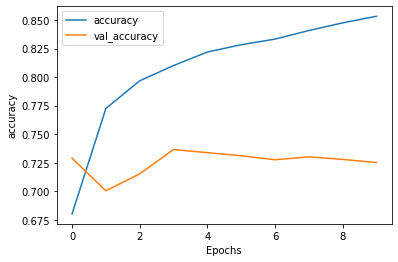

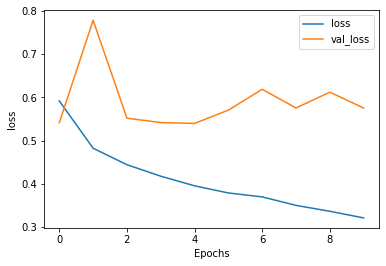

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')